In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import rotate
from pytomography.utils import rotate_detector_z
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


I've really been pushing the notation

$$H = \sum_{\theta} P(\theta) A(\theta) \otimes \hat{\theta}$$

but its often better to reframe it as

$$H = \sum_{\theta} P(\theta) A(\theta) R(\theta) \otimes \hat{\theta}$$

where $R$ is a rotation matrix that rotates the object before applying corrections (this is what we've been doing in the code).

* $A$ applies some sort of correction (attenuation/PSF) to the object before $P$ projects it to image space. Lets call $\mathbb{U}$ the vector space of objects, $\mathbb{V}$ the vector space of images, and $\mathbb{V}_{\theta}$ as the vector space of projections. Note: an image consists of multiple projections, so $\mathbb{V}_{\theta}$ is a subspace of $\mathbb{V}$, and $\bigcup_{\theta} \mathbb{V}_{\theta} = \mathbb{V}$, so in mathematical terms, the $\mathbb{V}_{\theta}$ **partition** the image space.

then we can express the mappings as 
* $R:\mathbb{U}\to\mathbb{U}$
* $A:\mathbb{U}\to\mathbb{U}$
* $P:\mathbb{U} \to \mathbb{V}_{\theta}$

In general, we can link these mappings $A$ together to perform multiple corrections. For example, if we want to perform CT **and** PSF correction, then

$$H = \sum_{\theta} P(\theta) A_2(\theta) A_1(\theta) R(\theta) \otimes \hat{\theta}$$

where $A_2$ applies PSF blurring and $A_1$ applies attenuation correction

In [3]:
dx = 0.3 #cm
x = torch.linspace(-1,1,128)
xv, yv, zv = torch.meshgrid(x,x,x, indexing='ij')
# SPECT Object
obj = (xv**2 + 0.9*zv**2 < 0.5) * (torch.abs(yv)<0.8)
obj = obj.to(torch.float).unsqueeze(dim=0)
# CT Object
mu = (xv**2 + 0.9*zv**2 < 0.3) * (torch.abs(yv)<0.6)
mu = mu.to(torch.float).unsqueeze(dim=0) * 0.1 #cm^-1

All the functions defined in the past few tutorials

In [4]:
dx = 0.3
radius = 25
Lx = 128
# PSF Stuff
collimator_slope = 0.07
collimator_intercept = 0.1

def rev_cumsum(x: torch.Tensor):
    return torch.cumsum(x.flip(dims=(1,)), dim=1).flip(dims=(1,)) - x/2

def get_distance(Lx: int, R: float, dx: float):
    if Lx%2==0:
        r = R + (Lx/2 - np.arange(Lx) - 1/2) * dx
    else:
        r = R + ((Lx-1)/2 - np.arange(Lx) ) * dx
    # Correction for if radius of scanner is inside the the bounds
    r[r<0] = 0
    return r

def get_sigma(
        radius: float,
        dx: float,
        Lx: tuple,
        collimator_slope: float,
        collimator_intercept: float
    ) -> np.array:
        distances = get_distance(Lx, radius, dx)
        sigma = collimator_slope * distances + collimator_intercept
        return sigma
# Get Attenuation Stuff


# Get PSF Stuff
sigma = get_sigma(radius=radius, dx=dx, Lx=Lx, collimator_slope=collimator_slope, collimator_intercept=collimator_intercept)   
N = len(sigma)
kernel_size = 45
delta = 1e-9
layer = torch.nn.Conv2d(N, N, kernel_size, groups=N, padding='same',
                        padding_mode='zeros', bias=0)
x_grid, y_grid = torch.meshgrid(2*[torch.arange(-int(kernel_size//2), int(kernel_size//2)+1)], indexing='ij')
x_grid = x_grid.unsqueeze(dim=0).repeat((N,1,1))
y_grid = y_grid.unsqueeze(dim=0).repeat((N,1,1))
sigma = torch.tensor(sigma, dtype=torch.float32).reshape((N,1,1))
kernel = torch.exp(-(x_grid**2 + y_grid**2) / (2*sigma**2 + delta))
kernel = kernel / kernel.sum(axis=(1,2)).reshape(N,1,1)
layer.weight.data = kernel.unsqueeze(dim=1)

In [5]:
obj.sum(axis=1).shape

torch.Size([1, 128, 128])

In [7]:
# Forward Projection
angles = torch.arange(0,360.,3)
image = torch.zeros((1,len(angles),128,128))
for i,angle in enumerate(angles):
    # Apply operation R
    object_i = rotate_detector_z(obj,angle)
    # Apply operation A1 (CT Correction)
    mu_i = rotate_detector_z(mu, angle)
    p_i = torch.exp(-rev_cumsum(mu_i * dx))
    object_i  = object_i * p_i
    # Apply operation A2 (PSF)
    object_i = layer(object_i)
    # Apply operation P
    projection = object_i.sum(axis=1)
    # Add to image (effectively $\otimes \hat{\theta}$)
    image[:,i] = projection
image = image.detach() #because was passed through network

Now we've applied both attenuation and PSF correction to the image:

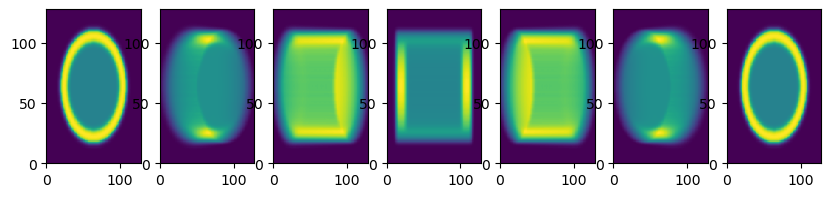

In [8]:
iis = [0,10,20,30,40,50,60]
fig, ax = plt.subplots(1,7,figsize=(10,2))
[a.pcolormesh(image[0,i].T) for (a, i) in zip(ax, iis)]
plt.show()

Notice that the individual components can be compartmentalized:
* Matrices $A$ are referred to as **transforms** and they're implementation is in `pytomography.transforms`
* The system matrix $H$ has implementation in `pytomography.projections`. This system matrix takes in the corresponding transforms, and implements forward/back projection
* Any metadata about the object, image, or projection, is stored in seperate objects with implementation in `pytomography.metadata`

In [10]:
from pytomography.projections import SystemMatrix

ModuleNotFoundError: No module named 'pytomography.projections'

In [11]:
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform

ImportError: cannot import name 'SPECTAttenuationTransform' from 'pytomography.transforms' (/Users/jjgomezcadenas/miniconda3/lib/python3.11/site-packages/pytomography/transforms/__init__.py)

In [12]:
import pytomography
from pytomography.metadata import ObjectMeta, ImageMeta, PSFMeta
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.projections import SystemMatrix
# Set device so its faster
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytomography.device = device

ImportError: cannot import name 'ImageMeta' from 'pytomography.metadata' (/Users/jjgomezcadenas/miniconda3/lib/python3.11/site-packages/pytomography/metadata/__init__.py)

Metadata

In [37]:
object_meta = ObjectMeta(dr=(0.3,0.3,0.3), shape=(128,128,128))
image_meta = ImageMeta(object_meta, angles=np.arange(0,360.,3), radii=25*np.ones(len(angles)))
psf_meta = PSFMeta(collimator_slope = 0.07, collimator_intercept=0.1)

Transforms

In [42]:
att_transform = SPECTAttenuationTransform(mu)
psf_transform = SPECTPSFTransform(psf_meta)

Projections (system matrix)

In [43]:
system_matrix = SystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    im2im_transforms = [],
    object_meta = object_meta,
    image_meta = image_meta)

Then everything can be ran quite simply:

In [44]:
image = system_matrix.forward(obj)

And plotted

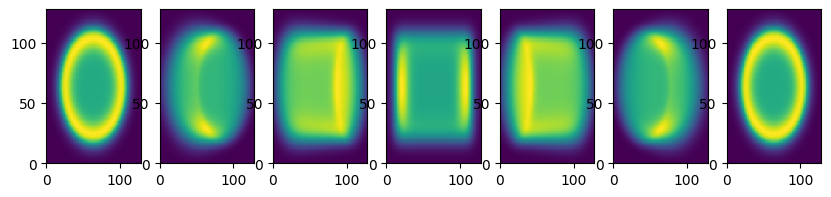

In [46]:
iis = [0,10,20,30,40,50,60]
fig, ax = plt.subplots(1,7,figsize=(10,2))
[a.pcolormesh(image[0,i].cpu().T) for (a, i) in zip(ax, iis)]
plt.show()